In [1]:
# models output : [buy, hold, sell]

In [2]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import keras
import keras.backend as K
from keras import models, layers, optimizers
from keras.losses import huber_loss
from keras.regularizers import L1L2

from collections import deque

import gc


Using TensorFlow backend.


In [3]:
class QNetwork:
    def __init__(self, input_size):
        self.model = make_models(input_size)


In [4]:
def make_models(input_size, output_size=2, n_layers=2):
    inputs = layers.Input(shape=(input_size, ))
    x = layers.Dense(16, activation='relu', kernel_regularizer = L1L2(l2= 0.001), kernel_initializer='he_normal')(inputs)

    for i in range(n_layers-1):
        x = layers.Dense(16//(2**(i+1)), kernel_regularizer=L1L2(l2= 0.001), kernel_initializer='he_normal')(x)
#         x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.1)(x)

    outputs = layers.Dense(output_size, activation='softmax')(x)

    m = models.Model(inputs, outputs)

    
    # AE weight initializer
#     encoder_inputs = layers.Input((18, ))
#     x = layers.Dense(16, activation='relu', kernel_regularizer=L1L2(l2 = 0.01))(encoder_inputs)
#     outputs = layers.Dense(18, activation='linear')(x)

#     model = models.Model(encoder_inputs, outputs)
#     encoder = models.Model(encoder_inputs, x)

#     model.compile(optimizer = 'adam',
#                  loss = 'mse')
    
#     model.fit(state, state, epochs=30, verbose=0)
    
#     encoder.layers[1].set_weights(model.layers[1].get_weights())
#     m.layers[1].set_weights(model.layers[1].get_weights())
    
#     new = encoder.predict(state)
#     del encoder_inputs, x, outputs, encoder, model
#     encoder_inputs = layers.Input((16, ))
#     x = layers.Dense(8, activation='relu', kernel_regularizer=L1L2(l2 = 0.01))(encoder_inputs)
#     outputs = layers.Dense(16, activation='linear')(x)

#     model = models.Model(encoder_inputs, outputs)

#     model.compile(optimizer = 'adam',
#                  loss = 'mse')

#     model.fit(new, new, epochs=30, verbose=0)

#     m.layers[2].set_weights(model.layers[1].get_weights())
#     del model, encoder_inputs, outputs, x
    
    m.compile(optimizer = optimizers.Adam(lr=1e-4),
             loss = 'categorical_crossentropy')

    return m

In [5]:
class Memory:
    def __init__(self):
        self.buffer = deque(maxlen=memory_size)
        
    def add(self, exp):
        self.buffer.append(exp)
        
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), size=batch_size, replace=False)
        return [self.buffer[i] for i in idx]
    
    def __len__(self):
        return len(self.buffer)
    
    

In [6]:
data = pd.read_csv('./data/stock.csv', thousands=',')
d = data.drop(['date', 'close', 'high', 'low'], axis=1)
d.columns

moving = pd.Series()
for cat in d.columns:
    for i in (5, 10, 30, 60):
        moving = pd.concat([moving, d[cat].rolling(i).mean()], axis=1)
        
moving.columns = ['0', 'moving_p5','moving_p10','moving_p30','moving_p60',
                  'moving_vol5','moving_vol10','moving_vol30','moving_vol60',
                  'moving_per5','moving_per10','moving_per30','moving_per60',
                  'moving_pbr5','moving_pbr10','moving_pbr30','moving_pbr60']

moving = moving.drop('0', axis=1)
moving = pd.concat([moving, data.high, data.low], axis=1)

X = moving[61:]
y = data.open[61:]

X = (X - np.min(X))/(np.max(X) - np.min(X))
# y = (y - np.min(y))/(np.max(y) - np.min(y))

state = X.values.copy()
p = y.values.copy()
# p = y.values.copy()
# p += 1e-5

In [13]:
# not reward clipped version
class Agent:
    def __init__(self, balance, state):
        self.fs = [balance, 0] # [cash, n_stock]
        self.balance = balance
        self.state = state
        self.main = make_models(18)
        self.learner = make_models(18)
        
        
    def train(self, n_steps):
        success_count = 0
        for n in range(n_steps):
            if success_count >= 5:
                break
            fs = [BALANCE, 0]
            balance = BALANCE
            step = 0
            steps = len(self.state)
            for i in range(0, steps-2):
                step += 1
                eps = 0.01 + (EPS - 0.01) * np.exp(-DECAY * step)

                self.learner.set_weights(self.main.get_weights())

                # action 
                if eps > np.random.rand():
                    action = np.random.choice([0, 1])
                else:
                    action = np.argmax(self.main.predict(state[i:i+1]))

                # current stock price
                price = p[i]
                # update fs
                fs = self.update_fs(fs, action, price)
                # update balance and make reward
                new_balance = self.update_balance(fs, price)

                reward = ((new_balance / balance) - 1)
                reward = self.clipping(reward)
#                 print(reward)

                balance = new_balance

                # memorize
                if step > WARMUP:
                    memory.add((state[i:i+1], action, reward, state[i+1:i+2]))

                # learner update
            for _ in range(10):

                np.random.seed(_)
                inputs = np.zeros((BATCH_SIZE, 18))
                targets = np.zeros((BATCH_SIZE, 2))

                minibatch = memory.sample(BATCH_SIZE)

                for j, (s, a, r, ss) in enumerate(minibatch):
                    inputs[j] = s
                    if not (ss == np.zeros(s.shape)).all(axis=1):
                        target = r + GAMMA * np.argmax(self.learner.predict(ss))
                    else:
                        target = r
                        
                    targets[j] = self.make_target(a, target)
                
#                     targets[j][a] = target

                self.main.fit(inputs, targets, epochs=1, verbose=0)
#                 print(i)


            # as episode end
                hist = self.simulation()
                hist = np.array(hist) - BALANCE
                plt.axhline(y=0, color='r', linestyle='-')
                plt.plot(hist)
                plt.show()
                print((_+1), 'steps','mean gain:', round(np.mean(hist)/BALANCE, 3))
                if np.mean(hist)/BALANCE == 0:
                    self.main = make_models(18)
                    
                if hist[-1] / BALANCE > 1:
                    success_count += 1
                else:
                    success_count = 0
                    
                if success_count >= 5:
                    break
                    
            
        return fs, balance
            
    def update_fs(self, fs, action, price):
        if action == 0: # buy
            n = fs[0] // price
            b = fs[0] % price
            new_n = fs[1]+ n
            return [b, new_n]
        
#         elif action == 1: # hold
#             return self.fs
        
        else: # sell
            b = fs[1] * price
            new_b = fs[0]+b
            return [new_b, 0]
        
    
    def update_balance(self, fs, price):
        b = fs[0] + fs[1] * price
#         print(b, self.fs)
        return b
        
    def simulation(self, debug=False):
        fs = [BALANCE, 0]
        balance = BALANCE
        hist = []
        sales = [0, 0]
        for i in range(len(state)-1):
            a = np.argmax(self.main.predict(self.state[i:i+1]))
            price = p[i]
            fs = self.update_fs(fs, a, price)
            balance = self.update_balance(fs, price)
            hist.append(balance)
            sales[a] += 1
            if debug:
                print(sales, balance)
        print(sales)
        return hist
    
    def clipping(self, r):
        if r > 0: return 1
        elif r < 0 : return -1
        else: return 0
        
    def make_target(self, action, target):
        if action == 0 : 
            return [max(target, 0), max(-target, 0)]
        else:
            return [max(-target, 0), max(target, 0)]

In [14]:
K.clear_session()

GAMMA = 0.99
WARMUP = 0
N_EPISODES = 1000
EPS = 0.1
DECAY = 0.001

memory_size = 1000
BATCH_SIZE = 512

BALANCE = 10000000

memory = Memory()
a = Agent(BALANCE, state)
gc.collect()

219591

[1195, 2044]


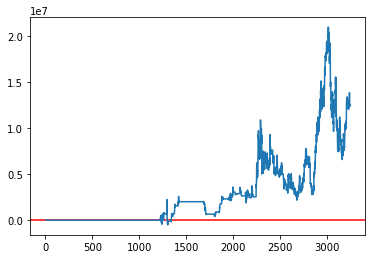

1 steps mean gain: 0.296
[1128, 2111]


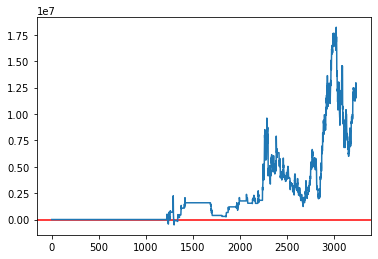

2 steps mean gain: 0.243
[1062, 2177]


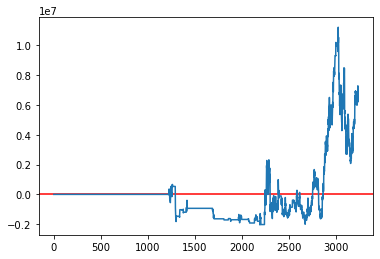

3 steps mean gain: 0.011
[987, 2252]


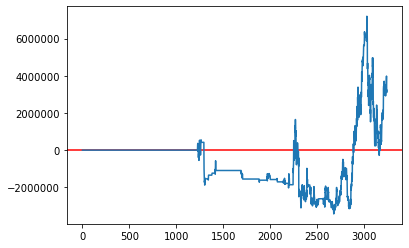

4 steps mean gain: -0.055
[902, 2337]


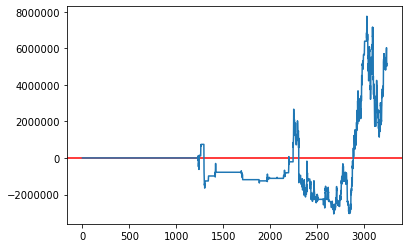

5 steps mean gain: -0.018
[863, 2376]


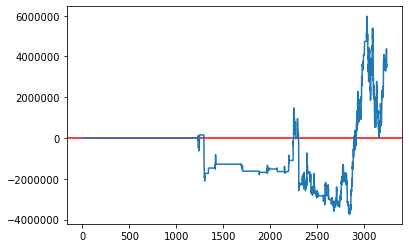

6 steps mean gain: -0.063
[847, 2392]


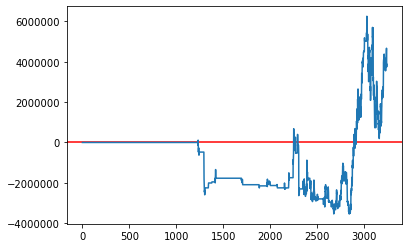

7 steps mean gain: -0.076
[751, 2488]


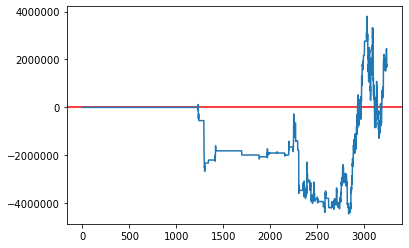

8 steps mean gain: -0.118
[703, 2536]


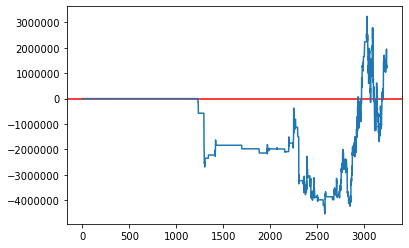

9 steps mean gain: -0.122
[639, 2600]


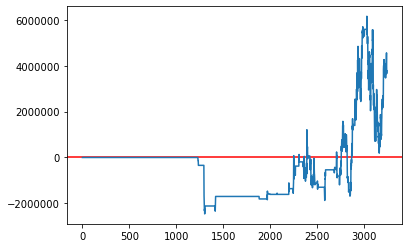

10 steps mean gain: -0.026
[436, 2803]


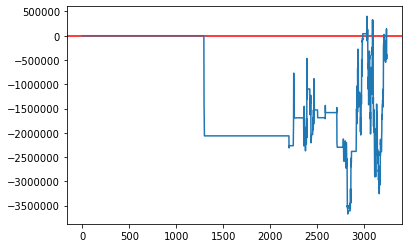

1 steps mean gain: -0.112
[240, 2999]


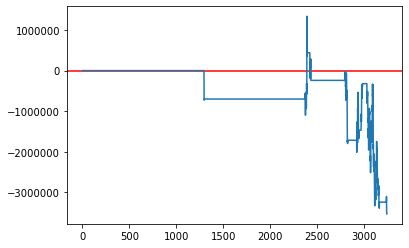

2 steps mean gain: -0.05
[48, 3191]


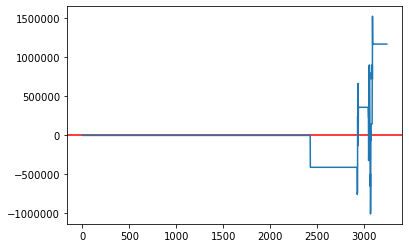

3 steps mean gain: 0.001
[1, 3238]


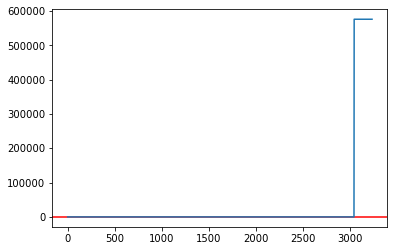

4 steps mean gain: 0.003
[0, 3239]


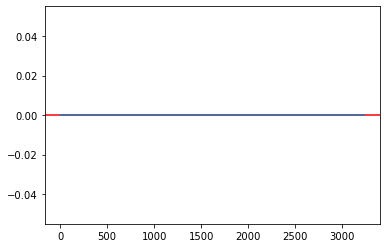

5 steps mean gain: 0.0
[0, 3239]


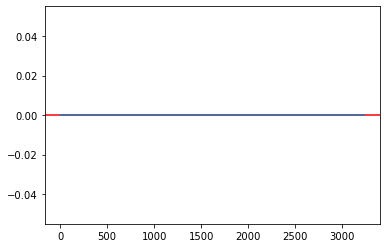

6 steps mean gain: 0.0
[1571, 1668]


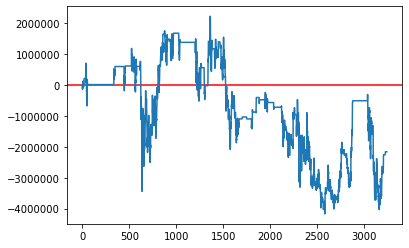

7 steps mean gain: -0.071
[1357, 1882]


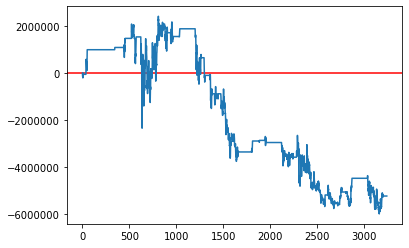

8 steps mean gain: -0.177
[1133, 2106]


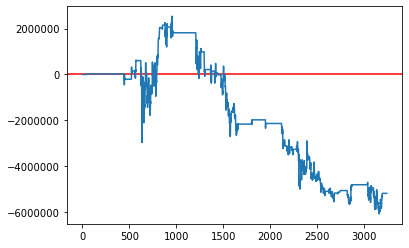

9 steps mean gain: -0.173
[925, 2314]


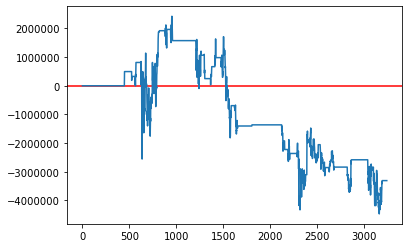

10 steps mean gain: -0.089
[622, 2617]


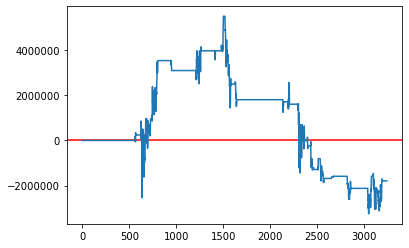

1 steps mean gain: 0.085
[387, 2852]


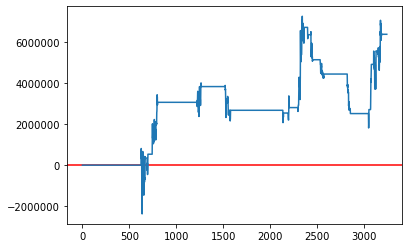

2 steps mean gain: 0.273
[181, 3058]


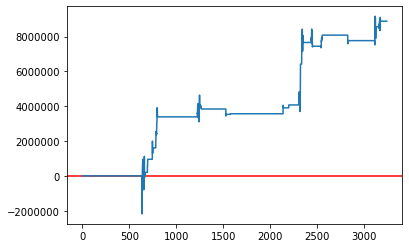

3 steps mean gain: 0.401
[71, 3168]


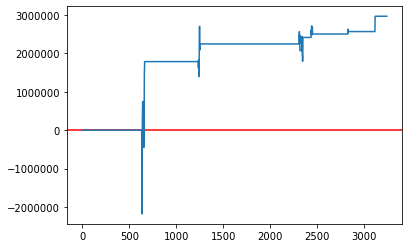

4 steps mean gain: 0.18
[24, 3215]


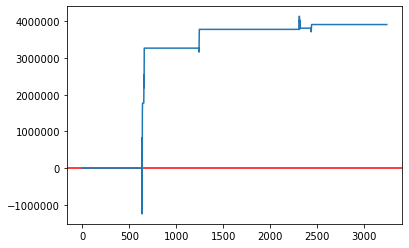

5 steps mean gain: 0.297
[11, 3228]


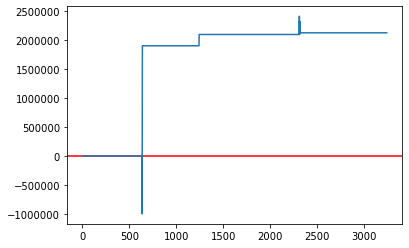

6 steps mean gain: 0.165
[7, 3232]


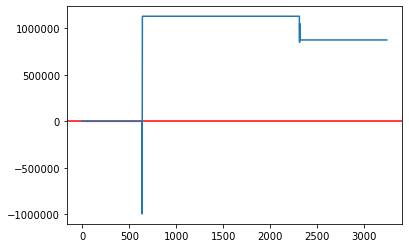

7 steps mean gain: 0.083
[1, 3238]


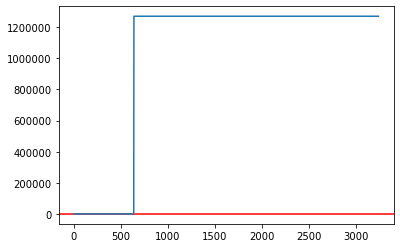

8 steps mean gain: 0.102
[0, 3239]


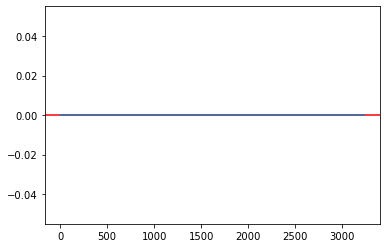

9 steps mean gain: 0.0
[79, 3160]


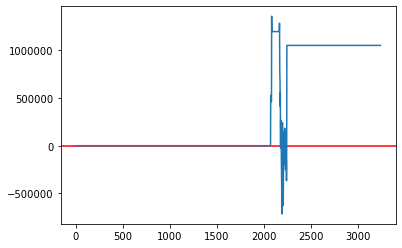

10 steps mean gain: 0.036
[47, 3192]


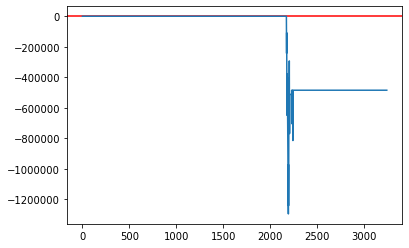

1 steps mean gain: -0.016


KeyboardInterrupt: 

In [15]:
%%time
a.train(10)

In [10]:
gc.collect()

65156

In [11]:
a.main.predict(state)

array([[0.5783164 , 0.4216836 ],
       [0.5846919 , 0.4153081 ],
       [0.5761019 , 0.42389816],
       ...,
       [0.45756003, 0.54244   ],
       [0.4560663 , 0.5439337 ],
       [0.44772488, 0.5522752 ]], dtype=float32)

In [12]:
hist = a.simulation(debug=True)

[1, 0] 10000000
[2, 0] 9866074
[3, 0] 10022338
[4, 0] 9988848
[5, 0] 9944206
[6, 0] 9921902
[7, 0] 9966544
[8, 0] 10000000
[9, 0] 10133926
[10, 0] 10078132
[11, 0] 9966544
[12, 0] 10033490
[13, 0] 10145078
[14, 0] 10145078
[15, 0] 10256700
[16, 0] 9921902
[17, 0] 9743334
[18, 0] 9966544
[19, 0] 9988848
[20, 0] 10245548
[21, 0] 10345984
[22, 0] 10345984
[23, 0] 10580346
[24, 0] 10212058
[25, 0] 10256700
[26, 0] 10435268
[27, 0] 10379440
[28, 0] 10368288
[29, 0] 10345984
[30, 0] 10468724
[31, 0] 10312494
[32, 0] 10412930
[33, 0] 10200906
[34, 0] 9732148
[35, 0] 9609408
[36, 0] 10066980
[37, 0] 10145078
[38, 0] 10000000
[39, 0] 10234362
[40, 0] 10636140
[41, 0] 10569194
[42, 0] 10401778
[43, 0] 9933054
[44, 0] 9899564
[45, 0] 9810280
[46, 0] 9508972
[47, 0] 9408502
[48, 0] 9252272
[49, 0] 9274610
[50, 0] 9575918
[51, 0] 9698692
[52, 0] 10066980
[53, 0] 10111622
[54, 0] 9944206
[55, 0] 9921902
[56, 0] 9676354
[57, 0] 9587070
[58, 0] 9564766
[59, 0] 9598256
[60, 0] 9620560
[61, 0] 9966544
[

[575, 4] 10918433
[576, 4] 11676674
[577, 4] 11849990
[578, 4] 11698322
[579, 4] 11741651
[580, 4] 11784980
[581, 4] 12001625
[582, 4] 11763332
[583, 4] 11914967
[584, 4] 12153260
[585, 4] 12239918
[586, 4] 11979977
[587, 4] 12109931
[588, 4] 12174941
[589, 4] 12066602
[590, 4] 12001625
[591, 4] 11958296
[592, 4] 11720003
[593, 4] 11460029
[594, 4] 11720003
[595, 4] 12001625
[596, 4] 11914967
[597, 4] 11546687
[598, 4] 11763332
[599, 4] 11806661
[600, 4] 11893319
[601, 4] 12196589
[602, 4] 12196589
[603, 4] 12153260
[604, 4] 12218270
[605, 4] 12153260
[606, 4] 11849990
[607, 4] 11914967
[608, 4] 11416700
[609, 4] 11286713
[610, 4] 11590016
[611, 4] 11784980
[612, 4] 11936648
[613, 4] 11720003
[614, 4] 12413234
[615, 4] 12369905
[616, 4] 11893319
[617, 4] 11286713
[618, 4] 10918433
[619, 4] 10571801
[620, 4] 9986876
[621, 4] 9791912
[621, 5] 10604306
[622, 5] 10604306
[623, 5] 10127687
[624, 5] 10257674
[625, 5] 10106039
[626, 5] 10366013
[627, 5] 9564443
[628, 5] 8504221
[629, 5] 92073

[971, 181] 9979949
[972, 181] 9826341
[973, 181] 9945811
[974, 181] 9911673
[975, 181] 9962893
[976, 181] 10133583
[977, 181] 10150639
[978, 181] 10116501
[979, 181] 10235971
[980, 181] 10270109
[981, 181] 10082363
[982, 181] 9962893
[983, 181] 10082363
[984, 181] 9894617
[985, 181] 9962893
[986, 181] 9962893
[987, 181] 10065307
[988, 181] 10031169
[989, 181] 9997031
[990, 181] 9775121
[991, 181] 9877535
[992, 181] 9860479
[993, 181] 9860479
[994, 181] 9877535
[995, 181] 9894617
[996, 181] 10065307
[997, 181] 10167721
[998, 181] 10389605
[999, 181] 10492019
[1000, 181] 10526157
[1001, 181] 10509075
[1002, 181] 11720935
[1003, 181] 10884593
[1004, 181] 10799235
[1005, 181] 10713903
[1006, 181] 10628571
[1007, 181] 10730959
[1008, 181] 10406661
[1009, 181] 10833373
[1010, 181] 10884593
[1011, 181] 10918731
[1012, 181] 10765097
[1013, 181] 10628571
[1014, 181] 10577351
[1015, 181] 10474937
[1016, 181] 10167721
[1017, 181] 10014087
[1018, 181] 10492019
[1019, 181] 10201833
[1020, 181] 1003

[1113, 604] 6991783
[1113, 605] 6991783
[1113, 606] 6991783
[1113, 607] 6991783
[1113, 608] 6991783
[1113, 609] 6991783
[1113, 610] 6991783
[1113, 611] 6991783
[1113, 612] 6991783
[1113, 613] 6991783
[1113, 614] 6991783
[1113, 615] 6991783
[1113, 616] 6991783
[1113, 617] 6991783
[1113, 618] 6991783
[1113, 619] 6991783
[1113, 620] 6991783
[1113, 621] 6991783
[1113, 622] 6991783
[1113, 623] 6991783
[1113, 624] 6991783
[1113, 625] 6991783
[1113, 626] 6991783
[1113, 627] 6991783
[1113, 628] 6991783
[1113, 629] 6991783
[1113, 630] 6991783
[1113, 631] 6991783
[1113, 632] 6991783
[1113, 633] 6991783
[1113, 634] 6991783
[1113, 635] 6991783
[1113, 636] 6991783
[1113, 637] 6991783
[1113, 638] 6991783
[1113, 639] 6991783
[1113, 640] 6991783
[1113, 641] 6991783
[1113, 642] 6991783
[1113, 643] 6991783
[1113, 644] 6991783
[1113, 645] 6991783
[1113, 646] 6991783
[1113, 647] 6991783
[1113, 648] 6991783
[1113, 649] 6991783
[1113, 650] 6991783
[1113, 651] 6991783
[1113, 652] 6991783
[1113, 653] 6991783


[1113, 1127] 6991783
[1113, 1128] 6991783
[1113, 1129] 6991783
[1113, 1130] 6991783
[1113, 1131] 6991783
[1113, 1132] 6991783
[1113, 1133] 6991783
[1113, 1134] 6991783
[1113, 1135] 6991783
[1113, 1136] 6991783
[1113, 1137] 6991783
[1113, 1138] 6991783
[1113, 1139] 6991783
[1113, 1140] 6991783
[1113, 1141] 6991783
[1113, 1142] 6991783
[1113, 1143] 6991783
[1113, 1144] 6991783
[1113, 1145] 6991783
[1113, 1146] 6991783
[1113, 1147] 6991783
[1113, 1148] 6991783
[1113, 1149] 6991783
[1113, 1150] 6991783
[1113, 1151] 6991783
[1113, 1152] 6991783
[1113, 1153] 6991783
[1113, 1154] 6991783
[1113, 1155] 6991783
[1113, 1156] 6991783
[1113, 1157] 6991783
[1113, 1158] 6991783
[1113, 1159] 6991783
[1113, 1160] 6991783
[1113, 1161] 6991783
[1113, 1162] 6991783
[1113, 1163] 6991783
[1113, 1164] 6991783
[1113, 1165] 6991783
[1113, 1166] 6991783
[1113, 1167] 6991783
[1113, 1168] 6991783
[1113, 1169] 6991783
[1113, 1170] 6991783
[1113, 1171] 6991783
[1113, 1172] 6991783
[1113, 1173] 6991783
[1113, 1174] 

[1113, 1700] 6991783
[1113, 1701] 6991783
[1113, 1702] 6991783
[1113, 1703] 6991783
[1113, 1704] 6991783
[1113, 1705] 6991783
[1113, 1706] 6991783
[1113, 1707] 6991783
[1113, 1708] 6991783
[1113, 1709] 6991783
[1113, 1710] 6991783
[1113, 1711] 6991783
[1113, 1712] 6991783
[1113, 1713] 6991783
[1113, 1714] 6991783
[1113, 1715] 6991783
[1113, 1716] 6991783
[1113, 1717] 6991783
[1113, 1718] 6991783
[1113, 1719] 6991783
[1113, 1720] 6991783
[1113, 1721] 6991783
[1113, 1722] 6991783
[1113, 1723] 6991783
[1113, 1724] 6991783
[1113, 1725] 6991783
[1113, 1726] 6991783
[1113, 1727] 6991783
[1113, 1728] 6991783
[1113, 1729] 6991783
[1113, 1730] 6991783
[1113, 1731] 6991783
[1113, 1732] 6991783
[1113, 1733] 6991783
[1113, 1734] 6991783
[1113, 1735] 6991783
[1113, 1736] 6991783
[1113, 1737] 6991783
[1113, 1738] 6991783
[1113, 1739] 6991783
[1113, 1740] 6991783
[1113, 1741] 6991783
[1113, 1742] 6991783
[1113, 1743] 6991783
[1113, 1744] 6991783
[1113, 1745] 6991783
[1113, 1746] 6991783
[1113, 1747] 

[1113, 2094] 6991783
[1113, 2095] 6991783
[1113, 2096] 6991783
[1113, 2097] 6991783
[1113, 2098] 6991783
[1113, 2099] 6991783
[1113, 2100] 6991783
[1113, 2101] 6991783
[1113, 2102] 6991783
[1113, 2103] 6991783
[1113, 2104] 6991783
[1113, 2105] 6991783
[1113, 2106] 6991783
[1113, 2107] 6991783
[1113, 2108] 6991783
[1113, 2109] 6991783
[1113, 2110] 6991783
[1113, 2111] 6991783
[1113, 2112] 6991783
[1113, 2113] 6991783
[1113, 2114] 6991783
[1113, 2115] 6991783
[1113, 2116] 6991783
[1113, 2117] 6991783
[1113, 2118] 6991783
[1113, 2119] 6991783
[1113, 2120] 6991783
[1113, 2121] 6991783
[1113, 2122] 6991783
[1113, 2123] 6991783
[1113, 2124] 6991783
[1113, 2125] 6991783
[1113, 2126] 6991783
[1113, 2126]
